**Problem Statement 2**

Importing required packages

In [2]:
import numpy as np
import os
import PIL
import IPython.display as display
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import datetime
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finding out emotion classes, from train dataset

In [17]:
data_dir_train = pathlib.Path('./brain_dead_emotion_detection/Train/')
data_dir_test = pathlib.Path('./brain_dead_emotion_detection/Test/')
CLASS_NAMES = np.array([item.name for item in data_dir_train.glob('*') ])
CLASS_NAMES

array(['angry', 'happy', 'neutral', 'sad'], dtype='<U7')

Checking count of all images path of each emotion classes

In [18]:
angry_train = list(data_dir_train.glob('angry/*.png'))
happy_train = list(data_dir_train.glob('happy/*.png'))
neutral_train = list(data_dir_train.glob('neutral/*.png'))
sad_train = list(data_dir_train.glob('sad/*.png'))
angry_test = list(data_dir_test.glob('angry/*.png'))
happy_test = list(data_dir_test.glob('happy/*.png'))
neutral_test = list(data_dir_test.glob('neutral/*.png'))
sad_test = list(data_dir_test.glob('sad/*.png'))

print("No. of images in emotion class 'angry' in train dataset : ", len(angry_train))
print("No. of images in emotion class 'happy' in train dataset : ", len(happy_train))
print("No. of images in emotion class 'neutral' in train dataset : ", len(neutral_train))
print("No. of images in emotion class 'sad' in train dataset : ", len(sad_train))

print("No. of images in emotion class 'angry' in test dataset : ", len(angry_test))
print("No. of images in emotion class 'happy' in test dataset : ", len(happy_test))
print("No. of images in emotion class 'neutral' in test dataset : ", len(neutral_test))
print("No. of images in emotion class 'sad' in test dataset : ", len(sad_test))

No. of images in emotion class 'angry' in train dataset :  408
No. of images in emotion class 'happy' in train dataset :  595
No. of images in emotion class 'neutral' in train dataset :  399
No. of images in emotion class 'sad' in train dataset :  408
No. of images in emotion class 'angry' in test dataset :  80
No. of images in emotion class 'happy' in test dataset :  105
No. of images in emotion class 'neutral' in test dataset :  102
No. of images in emotion class 'sad' in test dataset :  82


Checking 'Angry' images

brain_dead_emotion_detection\Train\angry\Aishwarya_Rai67.png
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=182x182 at 0x24619251F40>


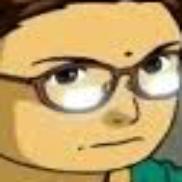

brain_dead_emotion_detection\Train\angry\Akhilesh_Yadav60.png
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=182x182 at 0x246193936D0>


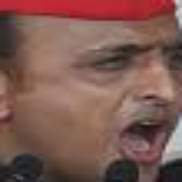

brain_dead_emotion_detection\Train\angry\Amit_Saha24.png
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=182x182 at 0x246193936D0>


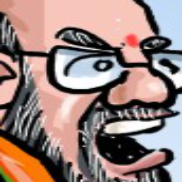

In [19]:
for image_path in angry_train[:3]:
    print(image_path)
    print(PIL.Image.open(str(image_path)))
    display.display(PIL.Image.open(str(image_path)))

Seting batch size, image height, image width, autotune

In [20]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_EPOCHS = 100 
AUTOTUNE=tf.data.experimental.AUTOTUNE


**Create a dataset regarding the file path**

In [21]:
X = angry_train + happy_train + neutral_train + sad_train
X = list(map(str, X))
X_test = angry_test + happy_test + neutral_test + sad_test
X_test = list(map(str, X_test))
print(X[0])
print(X_test[0])

brain_dead_emotion_detection\Train\angry\Aishwarya_Rai67.png
brain_dead_emotion_detection\Test\angry\cartoon_52_1229.png


**Convert file path to (image, label) pair**

Get labels from a file_path

In [22]:
def get_label(file_path):
  parts = file_path.split('\\')
  return parts[-2] == CLASS_NAMES

Process image - *convert an image into a grid format according to its RGB content*

In [23]:
def process_image(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3) #color images
  img = tf.image.convert_image_dtype(img, tf.float32) 
   #convert unit8 tensor to floats in the [0,1]range
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 
#resize the image into 224*224 

Get (image, label) pair for a given file_path

In [24]:
def get_image_label(file_path, label):
  img = process_image(file_path)
  return img, label

Creating Labels

In [25]:
y = [get_label(file_path) for file_path in X]
y_test = [get_label(file_path) for file_path in X_test]
print(y[0])
print(y_test[0])

[ True False False False]
[ True False False False]


Spliting data into training set and validation set

In [26]:
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Turning into batches

In [27]:
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch
  else:
    print("Creating train data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

In [28]:
# Create Training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)
test_data = create_data_batches(X_test, y_test, test_data=True)

Creating train data batches...
Creating validation data batches...
Creating test data batches...


In [29]:
train_data.element_spec, val_data.element_spec, test_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)))

In [30]:
# Setup input shape to the model
INPUT_SHAPE =[None, IMG_HEIGHT, IMG_WIDTH, 3] # batch, height, width, colour channels
OUTPUT_SHAPE = len(CLASS_NAMES)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [31]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", model_url)
  model = tf.keras.Sequential([
      hub.KerasLayer(model_url), # layer 1 (input layer) 
      # already many layers are present in this models
      tf.keras.layers.Dense(units=output_shape, activation='softmax') # layer 2 (output layer)
  ])

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

  model.build(input_shape)

  return model

In [42]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_1 (Dense)             (None, 4)                 4008      
                                                                 
Total params: 5,436,721
Trainable params: 4,008
Non-trainable params: 5,432,713
_________________________________________________________________


**tensorflow callback**

In [33]:
%load_ext tensorboard

In [34]:
def create_tensorboard_callback():
  logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [35]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

**Training Model**

In [46]:
def train_model(model, no_epochs = NUM_EPOCHS):
  tensorboard = create_tensorboard_callback()
  model.fit(x=train_data, epochs=no_epochs, validation_data=val_data, validation_freq=1, callbacks=[tensorboard, early_stopping])
  return model

In [47]:
model = train_model(model)

Epoch 1/100
46/46 [==============================] - 53s 1s/step - loss: 1.5202 - accuracy: 0.4213 - val_loss: 1.1139 - val_accuracy: 0.5470
Epoch 2/100
46/46 [==============================] - 43s 946ms/step - loss: 0.9448 - accuracy: 0.5988 - val_loss: 0.9537 - val_accuracy: 0.6050
Epoch 3/100
46/46 [==============================] - 43s 947ms/step - loss: 0.7800 - accuracy: 0.6837 - val_loss: 0.8407 - val_accuracy: 0.6409
Epoch 4/100
46/46 [==============================] - 47s 1s/step - loss: 0.7159 - accuracy: 0.7141 - val_loss: 0.7990 - val_accuracy: 0.6657
Epoch 5/100
46/46 [==============================] - 47s 1s/step - loss: 0.6298 - accuracy: 0.7376 - val_loss: 0.7727 - val_accuracy: 0.7044
Epoch 6/100
46/46 [==============================] - 45s 988ms/step - loss: 0.5838 - accuracy: 0.7728 - val_loss: 0.7521 - val_accuracy: 0.6906
Epoch 7/100
46/46 [==============================] - 43s 947ms/step - loss: 0.5401 - accuracy: 0.7818 - val_loss: 0.7119 - val_accuracy: 0.7376
E

**Making predictions**

In [52]:
predictions = model.predict(test_data, verbose=1)
predictions

12/12 [==============================] - 12s 915ms/step


array([[1.0039494e-02, 1.5266427e-03, 6.4416823e-04, 9.8778963e-01],
       [1.5221982e-01, 2.0286025e-01, 2.5925609e-01, 3.8566384e-01],
       [3.6511603e-01, 4.6961762e-02, 2.0419469e-01, 3.8372752e-01],
       ...,
       [2.2473344e-01, 4.2969838e-02, 3.6596265e-03, 7.2863704e-01],
       [5.8962429e-05, 1.4239570e-01, 1.2626776e-02, 8.4491855e-01],
       [3.7839310e-03, 1.1568983e-01, 5.6279415e-01, 3.1773201e-01]],
      dtype=float32)

In [53]:
predictions.shape

(369, 4)

In [54]:
index=42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {CLASS_NAMES[np.argmax(predictions[index])]}")

[0.12468068 0.7357239  0.13883303 0.00076231]
Max value (probability of prediction): 0.7357239127159119
Max index: 1
Predicted label: happy


In [84]:
# prediction labels
def get_name_label(prediction_probabilities):
  return CLASS_NAMES[np.argmax(prediction_probabilities)]

pred_label = get_name_label(predictions[81])
pred_label

'happy'

Save and Load Model

In [25]:
def save_model(model, suffix=None):
  modeldir = os.path.join("./models", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir+"-"+suffix+".h5"
  print("saving at", model_path)
  model.save(model_path)
  return model_path

In [18]:
def load_model(model_path):
  print("load model from", model_path)
  model = tf.keras.models.load_model(model_path,custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [50]:
save_model(model, suffix="emotions")

saving at ./models\20230323-082710-emotions.h5


'./models\\20230323-082710-emotions.h5'

In [56]:
loaded_1000= load_model("./models/20230323-082710-emotions.h5")
loaded_1000.evaluate(test_data)

load model from ./models/20230323-082710-emotions.h5
12/12 [==============================] - 10s 814ms/step - loss: 1.2292 - accuracy: 0.5664


[1.2292470932006836, 0.56639564037323]

In [57]:
loaded_1000.evaluate(val_data)

12/12 [==============================] - 11s 877ms/step - loss: 0.6782 - accuracy: 0.7514


[0.6781814098358154, 0.7513812184333801]

In [109]:
# print(test_data)
pred_class = []
test_class = []
for i in predictions:
    pred_class.append(np.argmax(i, axis=0))
for i,j in test_data.unbatch():
    # print(np.argmax(j, axis=0))
    test_class.append(np.argmax(j, axis=0))
pred_class = np.asarray(pred_class)
test_class = np.asarray(test_class)
pred_class = pred_class.reshape(-1, 1)
test_class = test_class.reshape(-1, 1)
pred_class.shape, test_class.shape

((369, 1), (369, 1))

In [111]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_class, pred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_class, pred_class, average='micro')
print('Precision: %f' % precision)
# # recall: tp / (tp + fn)
recall = recall_score(test_class, pred_class, average='micro')
print('Recall: %f' % recall)
# # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_class, pred_class, average='micro')
print('F1 score: %f' % f1)
# # kappa
kappa = cohen_kappa_score(test_class, pred_class)
print('Cohens kappa: %f' % kappa)
# # ROC AUC
# auc = roc_auc_score(test_class, pred_class, multi_class='ovr')
# print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_class, pred_class)
print('Confusion Matrix',matrix)

Accuracy: 0.566396
Precision: 0.566396
Recall: 0.566396
F1 score: 0.566396
Cohens kappa: 0.417430
Confusion Matrix [[40 11 11 18]
 [11 54 33  7]
 [ 6 26 66  4]
 [13  2 18 49]]


Image Augmentations

In [10]:
tt2 = tf.keras.preprocessing.image_dataset_from_directory(
    './brain_dead_emotion_detection/Train/',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)
print(tt2)
print(len(tt2))
# tt = tf.io.read_file(X[26])
# tt = tf.image.decode_jpeg(tt, channels=3)
# tt=tf.image.convert_image_dtype(tt, tf.float32)[:2]
# tt=tf.image.resize(tt, [IMG_WIDTH, IMG_HEIGHT])
# datagen = ImageDataGenerator(
#     rotation_range=270,
#     width_shift_range=1.0,
#     height_shift_range=1.0,
#     # horizontal_flip=True,
#     validation_split=0.0)
# datagen.fit(tt)

Found 1810 files belonging to 4 classes.
Using 362 files for validation.
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
12


In [42]:
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=1.0,
        height_shift_range=1.0,
        shear_range=0.2,
        zoom_range=0.5,
        horizontal_flip=True,
        fill_mode='nearest',  validation_split=0.2)

train_generator = datagen.flow_from_directory('./brain_dead_emotion_detection/Train/',target_size=(224, 224),
        shuffle=True,
        batch_size=32,
        subset="training",
        seed = 42,
        class_mode='categorical')

validation_generator = datagen.flow_from_directory('./brain_dead_emotion_detection/Train/',target_size=(224, 224),
        shuffle=True,
        batch_size=32,
        subset="validation",
        seed = 42,
        class_mode='categorical')


Found 1450 images belonging to 4 classes.
Found 360 images belonging to 4 classes.


In [43]:
model_new = create_model()
model_new.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_2 (Dense)             (None, 4)                 4008      
                                                                 
Total params: 5,436,721
Trainable params: 4,008
Non-trainable params: 5,432,713
_________________________________________________________________


In [46]:
model_new.fit(x=train_generator, epochs=10000, validation_data=validation_generator, validation_freq=1, callbacks=[create_tensorboard_callback(), early_stopping])

Epoch 1/10000
46/46 [==============================] - 57s 1s/step - loss: 1.0502 - accuracy: 0.5497 - val_loss: 1.2845 - val_accuracy: 0.4639
Epoch 2/10000
46/46 [==============================] - 57s 1s/step - loss: 0.9751 - accuracy: 0.5841 - val_loss: 1.2085 - val_accuracy: 0.4833
Epoch 3/10000
46/46 [==============================] - 58s 1s/step - loss: 0.9401 - accuracy: 0.5910 - val_loss: 1.1783 - val_accuracy: 0.5000
Epoch 4/10000
46/46 [==============================] - 62s 1s/step - loss: 0.8644 - accuracy: 0.6497 - val_loss: 1.2185 - val_accuracy: 0.4917
Epoch 5/10000
46/46 [==============================] - 63s 1s/step - loss: 0.8299 - accuracy: 0.6428 - val_loss: 1.2149 - val_accuracy: 0.5167
Epoch 6/10000
46/46 [==============================] - 57s 1s/step - loss: 0.8292 - accuracy: 0.6559 - val_loss: 1.2364 - val_accuracy: 0.4861
Epoch 7/10000
46/46 [==============================] - 64s 1s/step - loss: 0.8311 - accuracy: 0.6579 - val_loss: 1.2809 - val_accuracy: 0.5000

In [38]:
model_new.evaluate(validation_generator)

12/12 [==============================] - 11s 909ms/step - loss: 1.2304 - accuracy: 0.5000


[1.2304457426071167, 0.5]

In [47]:
model_new2 = create_model()
model_new2.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_3 (Dense)             (None, 4)                 4008      
                                                                 
Total params: 5,436,721
Trainable params: 4,008
Non-trainable params: 5,432,713
_________________________________________________________________


In [48]:
model_new2.fit(x=train_generator, epochs=100, validation_data=validation_generator, validation_freq=1, callbacks=[create_tensorboard_callback(), early_stopping])

Epoch 1/100
46/46 [==============================] - 66s 1s/step - loss: 1.7098 - accuracy: 0.3572 - val_loss: 1.3882 - val_accuracy: 0.3944
Epoch 2/100
46/46 [==============================] - 65s 1s/step - loss: 1.2349 - accuracy: 0.4834 - val_loss: 1.2751 - val_accuracy: 0.4361
Epoch 3/100
46/46 [==============================] - 61s 1s/step - loss: 1.0641 - accuracy: 0.5483 - val_loss: 1.3013 - val_accuracy: 0.4222
Epoch 4/100
46/46 [==============================] - 61s 1s/step - loss: 1.0187 - accuracy: 0.5779 - val_loss: 1.2448 - val_accuracy: 0.4778
Epoch 5/100
46/46 [==============================] - 63s 1s/step - loss: 0.9386 - accuracy: 0.6262 - val_loss: 1.2543 - val_accuracy: 0.5028
Epoch 6/100
46/46 [==============================] - 67s 1s/step - loss: 0.8996 - accuracy: 0.6159 - val_loss: 1.3144 - val_accuracy: 0.4556
Epoch 7/100
46/46 [==============================] - 64s 1s/step - loss: 0.8971 - accuracy: 0.6228 - val_loss: 1.2479 - val_accuracy: 0.4944
Epoch 8/100
4

In [49]:
datagen2 = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=1.0,
        height_shift_range=1.0,
        shear_range=0.2,
        zoom_range=0.5,
        horizontal_flip=True,
        fill_mode='nearest',  validation_split=0.2)

train_generator2 = datagen.flow_from_directory('./brain_dead_emotion_detection/Train/',target_size=(224, 224),
        shuffle=True,
        batch_size=16,
        subset="training",
        seed = 42,
        class_mode='categorical')

validation_generator2 = datagen.flow_from_directory('./brain_dead_emotion_detection/Train/',target_size=(224, 224),
        shuffle=True,
        batch_size=16,
        subset="validation",
        seed = 42,
        class_mode='categorical')
model_new3 = create_model()
# model_new.summary()
model_new3.fit(x=train_generator2, epochs=100, validation_data=validation_generator2, validation_freq=1, callbacks=[create_tensorboard_callback(), early_stopping])


Found 1450 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
91/91 [==============================] - 63s 653ms/step - loss: 1.5475 - accuracy: 0.4055 - val_loss: 1.3031 - val_accuracy: 0.4028
Epoch 2/100
91/91 [==============================] - 57s 629ms/step - loss: 1.1344 - accuracy: 0.5255 - val_loss: 1.3179 - val_accuracy: 0.4500
Epoch 3/100
91/91 [==============================] - 59s 652ms/step - loss: 1.0233 - accuracy: 0.5848 - val_loss: 1.2439 - val_accuracy: 0.4917
Epoch 4/100
91/91 [==============================] - 60s 661ms/step - loss: 0.9223 - accuracy: 0.6193 - val_loss: 1.2544 - val_accuracy: 0.4583
Epoch 5/100
91/91 [==============================] - 67s 736ms/step - loss: 0.9463 - accuracy: 0.6103 - val_loss: 1.3281 - val_accuracy: 0.4222
Epoch 6/100
91/91 [==============================] - 61s 668ms/step - loss: 0.8477 - accuracy: 0.6476 - 